In [1]:
using Revise
using Kinetic
using DifferentialEquations, Flux
using DiffEqFlux, Optim
using Plots, Dates
using FileIO, JLD2
using Printf

In [2]:
# generate parameters
config = "ude_config.txt"
D = read_dict(config)
for key in keys(D)
    s = Symbol(key)
    @eval $s = $(D[key])
end

case = homogeneous
maxTime = 1
tlen = 5
u0 = -5
u1 = 5
nu = 28
nug = 0
v0 = -5
v1 = 5
nv = 28
nvg = 0
w0 = -5
w1 = 5
nw = 28
nwg = 0
vMeshType = rectangle
nm = 5
knudsen = 1
inK = 0
alpha = 1.0
omega = 0.5
nh = 8



In [3]:
tspan = (0.0, maxTime)
tran = range(tspan[1], tspan[2], length = tlen)

γ = heat_capacity_ratio(inK, 3)
vSpace = VSpace3D(u0, u1, nu, v0, v1, nv, w0, w1, nw, vMeshType)

f0 =
    Float32.(
        0.5 * (1 / π)^1.5 .*
        (exp.(-(vSpace.u .- 0.99) .^ 2) .+ exp.(-(vSpace.u .+ 0.99) .^ 2)) .*
        exp.(-vSpace.v .^ 2) .* exp.(-vSpace.w .^ 2),
    ) |> Array
prim0 = conserve_prim(
    moments_conserve(f0, vSpace.u, vSpace.v, vSpace.w, vSpace.weights),
    γ,
)
M0 = Float32.(maxwellian(vSpace.u, vSpace.v, vSpace.w, prim0)) |> Array

mu_ref = ref_vhs_vis(knudsen, alpha, omega)
kn_bzm = hs_boltz_kn(mu_ref, 1.0)
τ = Float32(vhs_collision_time(prim0, mu_ref, 0.5))

phi, psi, phipsi = kernel_mode(
    nm,
    vSpace.u1,
    vSpace.v1,
    vSpace.w1,
    vSpace.du[1, 1, 1],
    vSpace.dv[1, 1, 1],
    vSpace.dw[1, 1, 1],
    vSpace.nu,
    vSpace.nv,
    vSpace.nw,
    alpha,
);

In [4]:
function boltzmann!(df, f::Array{<:Real,3}, p, t)
    Kn, M, phi, psi, phipsi = p
    df .= boltzmann_fft(f, Kn, M, phi, psi, phipsi) # https://github.com/vavrines/Kinetic.jl
end

function bgk!(df, f::Array{<:Real,3}, p, t)
    g, tau = p
    df .= (g .- f) ./ tau
end

# Boltzmann
prob = ODEProblem(boltzmann!, f0, tspan, [kn_bzm, nm, phi, psi, phipsi])
data_boltz = solve(prob, Tsit5(), saveat = tran) |> Array

# BGK
prob1 = ODEProblem(bgk!, f0, tspan, [M0, τ])
data_bgk = solve(prob1, Tsit5(), saveat = tran) |> Array

data_boltz_1D = zeros(Float32, axes(data_boltz, 1), axes(data_boltz, 4))
data_bgk_1D = zeros(Float32, axes(data_bgk, 1), axes(data_bgk, 4))
for j in axes(data_boltz_1D, 2), i in axes(data_boltz_1D, 1)
    data_boltz_1D[
        i,
        j,
    ] = sum(@. vSpace.weights[i, :, :] * data_boltz[i, :, :, j])
    data_bgk_1D[i, j] = sum(@. vSpace.weights[i, :, :] * data_bgk[i, :, :, j])
end

f0_1D = zeros(Float32, axes(f0, 1))
for i in axes(data_boltz_1D, 1)
    f0_1D[i] = sum(@. vSpace.weights[i, :, :] * f0[i, :, :])
end

M0_1D = zeros(Float32, axes(M0, 1))
for i in axes(M0, 1)
    M0_1D[i] = sum(@. vSpace.weights[i, :, :] * M0[i, :, :])
end

In [7]:
#--- universal differential equation ---#
model_univ = FastChain(
    (x, p) -> x .^ 2, # initial guess
    FastDense(vSpace.nu, vSpace.nu * nh, tanh),
    FastDense(vSpace.nu * nh, vSpace.nu * nh, tanh),
    FastDense(vSpace.nu * nh, vSpace.nu),
)

p_model = initial_params(model_univ)

p_all = [f0_1D; M0_1D; τ; p_model]

function dudt_univ!(df, f, p, t)
    M = p[nu+1:2*nu]
    τ = p[2*nu+1]
    p_nn = p[2*nu+2:end]
    df .= (M .- f) ./ τ .+ model_univ(f, p_nn)
end

prob_univ = ODEProblem(dudt_univ!, f0_1D, tspan, p_all)

function loss_ude(p)
    sol_univ = concrete_solve(prob_univ, Tsit5(), p[1:nu], p, saveat = tran)

    loss = sum(abs2, Array(sol_univ) .- data_boltz_1D)

    return loss
end

cb = function (p, l)
    display(l)
    return false
end

#9 (generic function with 1 method)

In [8]:
res = DiffEqFlux.sciml_train(
    loss_ude,
    p_all,
    ADAM(),
    cb = cb,
    maxiters = 200,
)

0.0012249792f0

loss: 0.00122:   0%|▎                                        |  ETA: 1:19:12

0.00072727626f0

loss: 0.000727:   1%|▍                                        |  ETA: 0:41:13

0.0006605834f0

loss: 0.000661:   2%|▋                                        |  ETA: 0:27:33

0.00056291034f0

loss: 0.000563:   2%|▉                                        |  ETA: 0:20:38

0.00032111883f0

loss: 0.000321:   2%|█                                        |  ETA: 0:16:32

0.00016908043f0

loss: 0.000169:   3%|█▎                                       |  ETA: 0:13:49

0.00020751657f0

0.0002903142f0

loss: 0.00029:   4%|█▋                                       |  ETA: 0:10:19

0.00029458522f0

0.00022277272f0

loss: 0.000223:   5%|██                                       |  ETA: 0:08:13

0.00012965704f0

6.79854f-5

loss: 6.8e-05:   6%|██▌                                      |  ETA: 0:06:49

6.5190485f-5

0.00010930256f0

loss: 0.000109:   7%|██▉                                      |  ETA: 0:05:49

0.00015237299f0

0.00014895014f0

loss: 0.000149:   8%|███▎                                     |  ETA: 0:05:04

9.8867866f-5

4.1839838f-5

loss: 4.18e-05:   9%|███▊                                     |  ETA: 0:04:29

1.734352f-5

3.349453f-5

loss: 3.35e-05:  10%|████▏                                    |  ETA: 0:04:01

6.652378f-5

8.478939f-5

loss: 8.48e-05:  11%|████▌                                    |  ETA: 0:03:38

7.50541f-5

4.8544138f-5

loss: 4.85e-05:  12%|████▉                                    |  ETA: 0:03:19

2.5623282f-5

loss: 2.56e-05:  12%|█████▏                                   |  ETA: 0:03:11

1.7906434f-5

2.3200935f-5

loss: 2.32e-05:  14%|█████▌                                   |  ETA: 0:02:56

3.264779f-5

3.8753566f-5

loss: 3.88e-05:  14%|██████                                   |  ETA: 0:02:43

3.8177917f-5

3.1445208f-5

loss: 3.14e-05:  16%|██████▍                                  |  ETA: 0:02:32

2.2274793f-5

1.5622472f-5

loss: 1.56e-05:  16%|██████▊                                  |  ETA: 0:02:22

1.4254918f-5

1.7264714f-5

loss: 1.73e-05:  18%|███████▏                                 |  ETA: 0:02:13

2.150021f-5

loss: 2.15e-05:  18%|███████▍                                 |  ETA: 0:02:09

2.3568697f-5

loss: 2.36e-05:  18%|███████▋                                 |  ETA: 0:02:05

2.1634989f-5

1.6719461f-5

loss: 1.67e-05:  20%|████████                                 |  ETA: 0:01:58

1.1900374f-5

loss: 1.19e-05:  20%|████████▎                                |  ETA: 0:01:55

9.917231f-6

1.150049f-5

loss: 1.15e-05:  21%|████████▋                                |  ETA: 0:01:49

1.47947585f-5

1.6474776f-5

loss: 1.65e-05:  22%|█████████                                |  ETA: 0:01:43

1.479121f-5

1.127631f-5

loss: 1.13e-05:  23%|█████████▍                               |  ETA: 0:01:38

8.883134f-6

loss: 8.88e-06:  24%|█████████▋                               |  ETA: 0:01:36

8.927651f-6

loss: 8.93e-06:  24%|█████████▉                               |  ETA: 0:01:34

1.0307862f-5

1.1296413f-5

loss: 1.13e-05:  25%|██████████▎                              |  ETA: 0:01:29

1.1151266f-5

loss: 1.12e-05:  26%|██████████▌                              |  ETA: 0:01:27

1.0121817f-5

8.921258f-6

loss: 8.92e-06:  26%|██████████▉                              |  ETA: 0:01:24

8.1569415f-6

loss: 8.16e-06:  27%|███████████▏                             |  ETA: 0:01:22

8.008127f-6

loss: 8.01e-06:  28%|███████████▎                             |  ETA: 0:01:20

8.334906f-6

loss: 8.33e-06:  28%|███████████▌                             |  ETA: 0:01:19

8.727553f-6

loss: 8.73e-06:  28%|███████████▋                             |  ETA: 0:01:17

8.719068f-6

8.1742755f-6

loss: 8.17e-06:  30%|████████████▏                            |  ETA: 0:01:14

7.4018362f-6

loss: 7.4e-06:  30%|████████████▎                            |  ETA: 0:01:12

6.917285f-6

loss: 6.92e-06:  30%|████████████▌                            |  ETA: 0:01:11

6.959851f-6

loss: 6.96e-06:  31%|████████████▊                            |  ETA: 0:01:09

7.2805415f-6

7.4321515f-6

loss: 7.43e-06:  32%|█████████████▏                           |  ETA: 0:01:07

7.15809f-6

loss: 7.16e-06:  32%|█████████████▍                           |  ETA: 0:01:05

6.6160123f-6

6.2121353f-6

loss: 6.21e-06:  34%|█████████████▊                           |  ETA: 0:01:03

6.1843334f-6

loss: 6.18e-06:  34%|██████████████                           |  ETA: 0:01:02

6.370786f-6

loss: 6.37e-06:  34%|██████████████▏                          |  ETA: 0:01:01

6.4227834f-6

loss: 6.42e-06:  35%|██████████████▍                          |  ETA: 0:01:00

6.2039326f-6

loss: 6.2e-06:  36%|██████████████▌                          |  ETA: 0:00:58

5.8885353f-6

loss: 5.89e-06:  36%|██████████████▊                          |  ETA: 0:00:57

5.6907656f-6

loss: 5.69e-06:  36%|███████████████                          |  ETA: 0:00:56

5.62701f-6

5.6108415f-6

loss: 5.61e-06:  38%|███████████████▍                         |  ETA: 0:00:54

5.58488f-6

5.497372f-6

loss: 5.5e-06:  38%|███████████████▊                         |  ETA: 0:00:52

5.329891f-6

5.14587f-6

loss: 5.15e-06:  40%|████████████████▎                        |  ETA: 0:00:50

5.0394538f-6

5.019749f-6

loss: 5.02e-06:  40%|████████████████▋                        |  ETA: 0:00:49

4.998457f-6

loss: 5e-06:  41%|████████████████▊                        |  ETA: 0:00:48

4.905731f-6

loss: 4.91e-06:  42%|█████████████████                        |  ETA: 0:00:47

4.759759f-6

4.6266755f-6

loss: 4.63e-06:  42%|█████████████████▍                       |  ETA: 0:00:45

4.5524516f-6

loss: 4.55e-06:  43%|█████████████████▋                       |  ETA: 0:00:45

4.522536f-6

4.4737844f-6

loss: 4.47e-06:  44%|██████████████████                       |  ETA: 0:00:43

4.3725977f-6

4.2553966f-6

loss: 4.26e-06:  45%|██████████████████▌                      |  ETA: 0:00:42

4.169163f-6

4.1141843f-6

loss: 4.11e-06:  46%|██████████████████▉                      |  ETA: 0:00:40

4.0603677f-6

3.9880524f-6

loss: 3.99e-06:  47%|███████████████████▎                     |  ETA: 0:00:39

3.9030674f-6

loss: 3.9e-06:  48%|███████████████████▌                     |  ETA: 0:00:38

3.8211488f-6

loss: 3.82e-06:  48%|███████████████████▋                     |  ETA: 0:00:38

3.7490588f-6

3.6872295f-6

loss: 3.69e-06:  49%|████████████████████▏                    |  ETA: 0:00:36

3.6302074f-6

loss: 3.63e-06:  50%|████████████████████▎                    |  ETA: 0:00:36

3.5645141f-6

3.4875854f-6

loss: 3.49e-06:  50%|████████████████████▊                    |  ETA: 0:00:34

3.4137365f-6

3.3529996f-6

loss: 3.35e-06:  52%|█████████████████████▏                   |  ETA: 0:00:33

3.2993207f-6

3.2397145f-6

loss: 3.24e-06:  52%|█████████████████████▌                   |  ETA: 0:00:32

3.1713755f-6

loss: 3.17e-06:  53%|█████████████████████▊                   |  ETA: 0:00:32

3.1041202f-6

3.045373f-6

loss: 3.05e-06:  54%|██████████████████████▏                  |  ETA: 0:00:31

2.9917485f-6

2.9357955f-6

loss: 2.94e-06:  55%|██████████████████████▌                  |  ETA: 0:00:29

2.874836f-6

2.8142779f-6

loss: 2.81e-06:  56%|███████████████████████                  |  ETA: 0:00:28

2.7586323f-6

loss: 2.76e-06:  56%|███████████████████████▏                 |  ETA: 0:00:28

2.706147f-6

2.653074f-6

loss: 2.65e-06:  58%|███████████████████████▋                 |  ETA: 0:00:27

2.598239f-6

2.5433728f-6

loss: 2.54e-06:  58%|████████████████████████                 |  ETA: 0:00:26

2.490653f-6

2.4403673f-6

loss: 2.44e-06:  60%|████████████████████████▍                |  ETA: 0:00:25

2.391104f-6

loss: 2.39e-06:  60%|████████████████████████▋                |  ETA: 0:00:25

2.340986f-6

2.2901124f-6

loss: 2.29e-06:  61%|█████████████████████████                |  ETA: 0:00:24

2.2408872f-6

2.1943083f-6

loss: 2.19e-06:  62%|█████████████████████████▍               |  ETA: 0:00:23

2.1482697f-6

2.1013623f-6

loss: 2.1e-06:  63%|█████████████████████████▉               |  ETA: 0:00:22

2.0546147f-6

2.009677f-6

loss: 2.01e-06:  64%|██████████████████████████▎              |  ETA: 0:00:21

1.9661943f-6

1.9229283f-6

loss: 1.92e-06:  65%|██████████████████████████▋              |  ETA: 0:00:20

1.8796575f-6

1.8369683f-6

loss: 1.84e-06:  66%|███████████████████████████              |  ETA: 0:00:20

1.7955293f-6

1.7550684f-6

loss: 1.76e-06:  67%|███████████████████████████▌             |  ETA: 0:00:19

1.7149447f-6

1.6752017f-6

loss: 1.68e-06:  68%|███████████████████████████▉             |  ETA: 0:00:18

1.6361206f-6

1.597932f-6

loss: 1.6e-06:  69%|████████████████████████████▎            |  ETA: 0:00:17

1.5605393f-6

1.5236652f-6

loss: 1.52e-06:  70%|████████████████████████████▊            |  ETA: 0:00:17

1.4871998f-6

loss: 1.49e-06:  70%|████████████████████████████▉            |  ETA: 0:00:16

1.4513423f-6

1.4163647f-6

loss: 1.42e-06:  72%|█████████████████████████████▍           |  ETA: 0:00:16

1.3821204f-6

1.34824f-6

loss: 1.35e-06:  72%|█████████████████████████████▊           |  ETA: 0:00:15

1.3148365f-6

loss: 1.31e-06:  73%|█████████████████████████████▉           |  ETA: 0:00:15

1.2822301f-6

loss: 1.28e-06:  74%|██████████████████████████████▏          |  ETA: 0:00:14

1.250333f-6

loss: 1.25e-06:  74%|██████████████████████████████▍          |  ETA: 0:00:14

1.2189577f-6

loss: 1.22e-06:  74%|██████████████████████████████▌          |  ETA: 0:00:14

1.1880069f-6

1.1576964f-6

loss: 1.16e-06:  76%|███████████████████████████████          |  ETA: 0:00:13

1.1280503f-6

loss: 1.13e-06:  76%|███████████████████████████████▏         |  ETA: 0:00:13

1.098994f-6

loss: 1.1e-06:  76%|███████████████████████████████▍         |  ETA: 0:00:12

1.0703977f-6

1.0423508f-6

loss: 1.04e-06:  78%|███████████████████████████████▊         |  ETA: 0:00:12

1.0149113f-6

9.88039f-7

loss: 9.88e-07:  78%|████████████████████████████████▏        |  ETA: 0:00:11

9.616895f-7

9.358563f-7

loss: 9.36e-07:  80%|████████████████████████████████▋        |  ETA: 0:00:11

9.105379f-7

8.8577275f-7

loss: 8.86e-07:  80%|█████████████████████████████████        |  ETA: 0:00:10

8.61548f-7

8.3778383f-7

loss: 8.38e-07:  82%|█████████████████████████████████▍       |  ETA: 0:00:09

8.145192f-7

7.9176f-7

loss: 7.92e-07:  82%|█████████████████████████████████▉       |  ETA: 0:00:09

7.6953313f-7

7.4775915f-7

loss: 7.48e-07:  84%|██████████████████████████████████▎      |  ETA: 0:00:08

7.2644156f-7

7.0564136f-7

loss: 7.06e-07:  84%|██████████████████████████████████▋      |  ETA: 0:00:08

6.852942f-7

6.654133f-7

loss: 6.65e-07:  86%|███████████████████████████████████      |  ETA: 0:00:07

6.4597043f-7

6.2697495f-7

loss: 6.27e-07:  86%|███████████████████████████████████▌     |  ETA: 0:00:07

6.084403f-7

5.9032584f-7

loss: 5.9e-07:  88%|███████████████████████████████████▉     |  ETA: 0:00:06

5.726328f-7

5.5536503f-7

loss: 5.55e-07:  88%|████████████████████████████████████▎    |  ETA: 0:00:05

5.3851943f-7

5.220962f-7

loss: 5.22e-07:  90%|████████████████████████████████████▊    |  ETA: 0:00:05

5.060496f-7

4.9041756f-7

loss: 4.9e-07:  90%|█████████████████████████████████████▏   |  ETA: 0:00:04

4.751596f-7

4.6030874f-7

loss: 4.6e-07:  92%|█████████████████████████████████████▌   |  ETA: 0:00:04

4.4582703f-7

4.3170084f-7

loss: 4.32e-07:  92%|█████████████████████████████████████▉   |  ETA: 0:00:03

4.1795414f-7

4.045597f-7

loss: 4.05e-07:  94%|██████████████████████████████████████▍  |  ETA: 0:00:03

3.9151064f-7

3.7880952f-7

loss: 3.79e-07:  94%|██████████████████████████████████████▊  |  ETA: 0:00:03

3.6645207f-7

3.5442886f-7

loss: 3.54e-07:  96%|███████████████████████████████████████▏ |  ETA: 0:00:02

3.4273316f-7

3.313497f-7

loss: 3.31e-07:  96%|███████████████████████████████████████▋ |  ETA: 0:00:02

3.2029607f-7

3.0952597f-7

loss: 3.1e-07:  98%|████████████████████████████████████████ |  ETA: 0:00:01

2.9907497f-7

2.8890992f-7

loss: 2.89e-07:  98%|████████████████████████████████████████▍|  ETA: 0:00:01

2.7903954f-7

2.6946637f-7

loss: 2.69e-07: 100%|████████████████████████████████████████▊|  ETA: 0:00:00

2.6014342f-7

loss: 2.6e-07: 100%|█████████████████████████████████████████| Time: 0:00:43


2.6014342f-7

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [-1.54e-05, -5.08e-06, 4.64e-05,  ...]
    Minimum:   2.601434e-07

 * Found with
    Algorithm:     ADAM
    Initial Point: [4.24e-08, 5.77e-07, 6.07e-06,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   44  (vs limit Inf)
    Iterations:    200
    f(x) calls:    200
    ∇f(x) calls:   200


In [9]:
sol_univ =
    concrete_solve(prob_univ, Tsit5(), f0_1D, res.minimizer, saveat = tran)

t: 5-element Array{Float64,1}:
 0.0 
 0.25
 0.5 
 0.75
 1.0 
u: 5-element Array{Array{Float32,1},1}:
 [4.244841e-8, 5.7678704e-7, 6.072677e-6, 4.9539947e-5, 0.0003131424, 0.0015336996, 0.005820435, 0.017116167, 0.03900967, 0.06895671  …  0.06895671, 0.03900967, 0.017116167, 0.005820435, 0.0015336996, 0.0003131424, 4.9539947e-5, 6.072677e-6, 5.7678704e-7, 4.244841e-8]             
 [2.5320282e-5, 8.204009e-6, -6.408472e-5, 0.00010798267, 0.00030600792, 0.0014109233, 0.0051609827, 0.015134305, 0.034330636, 0.06180061  …  0.061801653, 0.034363527, 0.015110042, 0.005316581, 0.0013971381, 0.00030701087, 3.41416e-5, 3.6860034e-5, -6.7806584e-5, 1.8328283e-5]    
 [2.7657243e-5, 1.36508825e-5, -5.472436e-5, 0.00010677915, 0.00029287624, 0.0013075465, 0.004656458, 0.013488662, 0.030618263, 0.056121193  …  0.056129538, 0.030639717, 0.013465445, 0.0048121847, 0.0012988177, 0.00028887918, 3.2535165e-5, 3.137977e-5, -6.4199456e-5, 1.8238203e-5]
 [1.3043213e-5, 9.204529e-6, -1.3585104e-5, 6.904043e

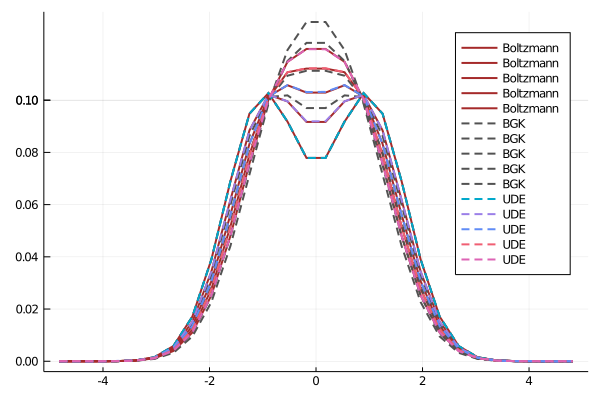

In [10]:
plot(
    vSpace.u[:, vSpace.nv÷2, vSpace.nw÷2],
    data_boltz_1D[:, :],
    lw = 2,
    label = "Boltzmann",
    color = :brown,
)
plot!(
    vSpace.u[:, vSpace.nv÷2, vSpace.nw÷2],
    data_bgk_1D[:, :],
    lw = 2,
    label = "BGK",
    line = :dash,
    color = :gray32,
)
plot!(
    vSpace.u[:, vSpace.nv÷2, vSpace.nw÷2],
    Array(sol_univ),
    lw = 2,
    label = "UDE",
    line = :dash,
)